# Week 9-2: Unsupervised Machine Learning met Apriori
Van Pjotr en Sennen.

Deze week hebben we het over ongesuperviseerde machine learning. Dit is een vorm van machine learning waarbij we geen gelabelde data hebben. Dit betekent dat we geen data hebben waarbij we weten wat de juiste output is. In plaats daarvan gaan we op zoek naar patronen in de data. Dit kan bijvoorbeeld zijn dat we clusters van data vinden, of dat we de data kunnen reduceren naar een kleinere dimensie.

Deze keer hebben we het over Frequent Itemsets met het A-Priori-algoritme. Dit is een algoritme dat gebruikt wordt om patronen te vinden in data. Het wordt vaak gebruikt in de retailsector om te kijken welke producten vaak samen worden gekocht. Dit kan bijvoorbeeld gebruikt worden om producten in een winkel anders te plaatsen, zodat producten die vaak samen worden gekocht ook dicht bij elkaar staan.


## De Opdracht
PR9-2: Great Outdoors wil graag weten welke producten vaak samen gekocht worden door klanten, door het bouwen van Frequent Itemsets met A-Priori-algoritme. Tip: merge eerst de tabellen 'product' en 'order_details' om een juiste tabel met brongegevens te krijgen waarop je het algoritme kan toepassen. 
- Pas waar nodig Dummy Encoding toe.
- Train het initiële algoritme.
- Experimenteer met meerdere support & confidence thresholds.
- De volgende webpagina's kun je als inspiratie gebruiken. Zij bevatten "codekapstokken" die uitleggen hoe je Frequent Itemsets moet maken en daarmee antwoord kunt geven op de vraag welke producten vaak samen gekocht worden.
    - [geeksforgeeks](https://www.geeksforgeeks.org/implementing-apriori-algorithm-in-python/)
    - [towardsdatascience](https://towardsdatascience.com/apriori-association-rule-mining-explanation-and-python-implementation-290b42afdfc6)

Eerst zorgen we ervoor dat we alle libraries hebben geimporteerd die we nodig hebben.

In [104]:
import numpy as np 
import pandas as pd 
from mlxtend.frequent_patterns import apriori, association_rules
import sqlite3
import matplotlib.pyplot as plt

Hierna gaan we onze data pakken die we nodig hebben. En de tabelen samenvoegen die we nodig hebben.

In [105]:
sales_conn = sqlite3.connect('data/go_sales.sqlite')

# Pak het Order Nummer en Product Nummer uit de order_details tabel.
order_details = pd.read_sql_query('SELECT * FROM order_details', sales_conn)
order_details = order_details[['ORDER_NUMBER', 'PRODUCT_NUMBER']]

# Pak de producten uit de product tabel.
products = pd.read_sql_query('SELECT * FROM product', sales_conn)
products = products[['PRODUCT_NUMBER', 'PRODUCT_NAME']]
dummy_products = pd.get_dummies(products['PRODUCT_NAME'])
products = products.drop('PRODUCT_NAME', axis=1)
products = pd.concat([products, dummy_products], axis=1)
products

,PRODUCT_NUMBER,Aloe Relief,Bear Edge,Bear Survival Edge,Blue Steel Max Putter,Blue Steel Putter,BugShield Extreme,BugShield Lotion,BugShield Lotion Lite,BugShield Natural,...,TrailChef Canteen,TrailChef Cook Set,TrailChef Cup,TrailChef Deluxe Cook Set,TrailChef Double Flame,TrailChef Kettle,TrailChef Kitchen Kit,TrailChef Single Flame,TrailChef Utensils,TrailChef Water Bag
0,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,10,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,100,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,101,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,102,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,95,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
111,96,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
112,97,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
113,98,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Hier gaan we de data mergen en de data met product id's en product namen samenvoegen. Die product namen zijn allemaal one hot encoded.

Daarna geven we de meest voorkomende producten weer. Die sorteren we en zetten in een balk grafiek.

Processing 193413 combinations | Sampling itemset size 3


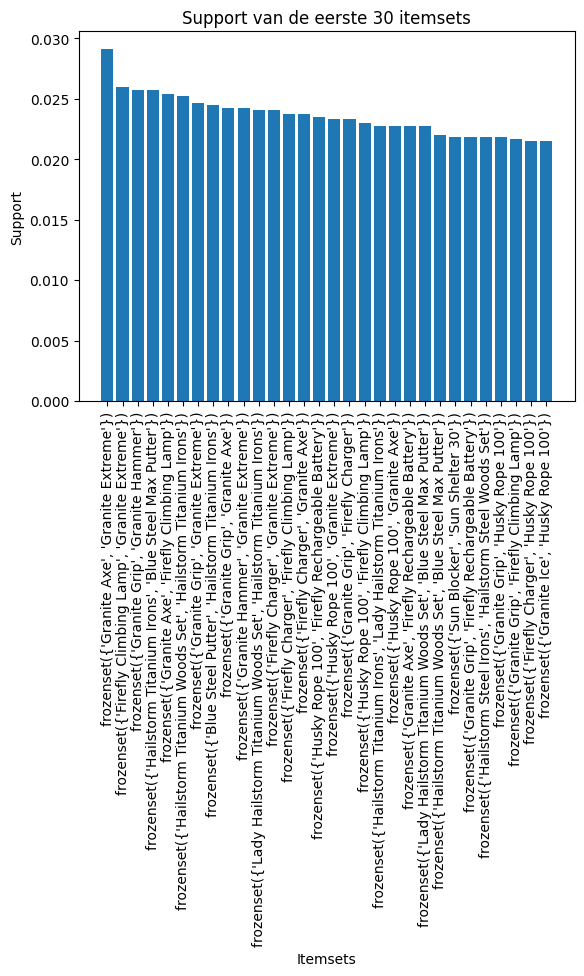

In [106]:
# Merge de order_details en products tabellen op PRODUCT_NUMBER
merged_data = pd.merge(order_details, products, on='PRODUCT_NUMBER', how='inner')

# Verwijder de kolommen die niet nodig zijn voor het algoritme
merged_data = merged_data.drop(['PRODUCT_NUMBER'], axis=1)
merged_data = merged_data.groupby('ORDER_NUMBER').aggregate('max')
merged_data
# Train het a-priori algoritme op de samengevoegde gegevens
frequent_itemsets = apriori(merged_data, min_support=0.01, verbose=True, use_colnames=True)

# # Sorteer de frequent_itemsets op basis van de support-waarden
sorted_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
sorted_itemsets = sorted_itemsets[sorted_itemsets['itemsets'].apply(lambda x: len(x) > 1)]

# Plot de frequentie van de itemsets
plt.bar(x = range(0, 30), height = sorted_itemsets['support'][0:30], tick_label = sorted_itemsets['itemsets'][0:30])
plt.xticks(rotation=90)
plt.title('Support van de eerste 30 itemsets')
plt.ylabel('Support')
plt.xlabel('Itemsets')
plt.show()


Hier worden de regels gegenereerd met behulp van de frequent_itemsets en de lift-metriek, daarmee kunnen we de regels sorteren op basis van de lift-waarden.

Lift waarden zijn een maat voor hoeveel meer de items samen worden gekocht dan verwacht op basis van de afzonderlijke support-waarden.

Hierna sorteren we de regels op basis van de lift-waarden en de confidence-waarden.

In [107]:
pd.set_option('display.max_colwidth', None)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules.sort_values(['lift', 'confidence'], ascending=[False, False])
filtered_rules = rules[rules.apply(lambda x: len(x['antecedents']) > 1, axis=1)]
antecedents = filtered_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
filtered_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
3584,"(Lady Hailstorm Titanium Irons, Blue Steel Max Putter)",(Lady Hailstorm Titanium Woods Set),0.019590,0.059142,0.010448,0.533333,9.017876,0.009289,2.016125,0.906874
3583,"(Lady Hailstorm Titanium Woods Set, Blue Steel Max Putter)",(Lady Hailstorm Titanium Irons),0.022761,0.054664,0.010448,0.459016,8.397023,0.009204,1.747439,0.901428
3582,"(Lady Hailstorm Titanium Woods Set, Lady Hailstorm Titanium Irons)",(Blue Steel Max Putter),0.020336,0.066791,0.010448,0.513761,7.692071,0.009090,1.919241,0.888055
